Version 2.2 concatenates all texts by only keeping sentences where bias is present.

In [1]:
!pip install -r ../requirements.txt

LOADING AND PREPROCESSING DATA + ANALYTICS

In [2]:
import pandas as pd
import transformers, torch

"""
Remove uneecessay new lines
remove duplicates within one cell
Remove links?
use keywords to make sure that correct classification is done
make validation set more class balanced, i.e. equal num of examples for each category
"""
# use keras instead of huggung face to make it easier to work with messing with layers
# keep latest entries only in original clean data
# double or triple (for some biases) rows that have social, gender, or subjective bias
# remove entries greater than 512 words to remove noise
# enchance data by repeating key terms
# cut 512 from middle of the dataset
# try giving it only the labels with 5 word context
# try doing subtext technique to give it 1000 words

# load data and rename TextEntry column
df = pd.read_csv("../carlos_data/preprocessed_data.csv", encoding="utf-8")
df = df.rename(columns={"TextEntry":"Description"})
df.drop(columns=['Subjective Label', 'Gender Label', 'Jargon Label', 'Social Label', "ANNOTATED?"], inplace=True)


/opt/homebrew/anaconda3/envs/carlos/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
import transformers, torch

# convert data to dictionary
data = df.to_dict("records")
# Split the data into train and validation and test sets
from sklearn.model_selection import train_test_split 
train_dict, test_dict = train_test_split(data, test_size=0.20, random_state=42) # specifying this random state allows for consistent train, val, and test sets
test_dict, validation_dict = train_test_split(test_dict, test_size=0.50, random_state=42) # same here

# Create Dataset objects
from datasets import Dataset
train_dataset = Dataset.from_list(train_dict)
test_dataset = Dataset.from_list(test_dict)
validation_dataset = Dataset.from_list(validation_dict)

# Create DatasetDict
from datasets import DatasetDict
dataset = DatasetDict({
	"train": train_dataset,
	"test": test_dataset,
	"validation": validation_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['ObjectID', 'Description', 'Subjective', 'Gender', 'Jargon', 'Social'],
        num_rows: 1442
    })
    test: Dataset({
        features: ['ObjectID', 'Description', 'Subjective', 'Gender', 'Jargon', 'Social'],
        num_rows: 180
    })
    validation: Dataset({
        features: ['ObjectID', 'Description', 'Subjective', 'Gender', 'Jargon', 'Social'],
        num_rows: 181
    })
})


Text(0.5, 0, 'Number of Words')

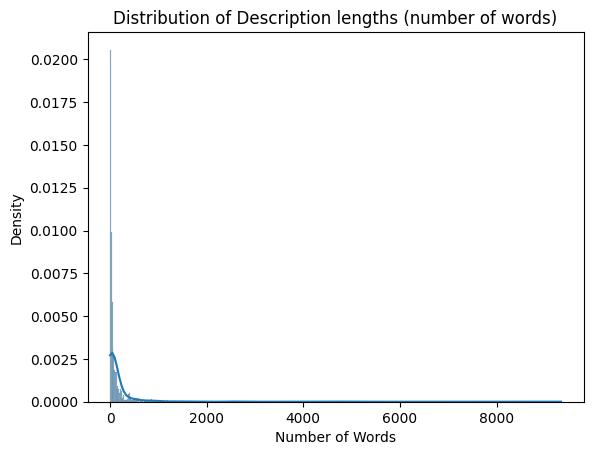

In [4]:
import seaborn as sns

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Description"], df["Social"], test_size=0.2, random_state=42
)

text_lengths = [len(t.split()) for t in train_texts]
ax = sns.histplot(data=text_lengths, kde=True, stat="density")
ax.set_title("Distribution of Description lengths (number of words)")
ax.set_xlabel("Number of Words")

ENCODING AND TOKENIZATION

In [5]:
# credit: https://github.com/NielsRogge/Transformers-Tutorials
labels = [label for label in dataset["train"].features.keys() if label not in ["ObjectID", "Description"]]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['Subjective', 'Gender', 'Jargon', 'Social']

In [6]:
from transformers import BertTokenizer
import numpy as np

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# credit: https://github.com/NielsRogge/Transformers-Tutorials
def preprocess_data(data):

	# save the given batch of descs
	descs = data["Description"]

	# encode them using bert tokenizer
	encoding = tokenizer(descs, padding=True, truncation=True, max_length=512)#.to("mps")

	# create numpy array (no need to convert T/F to 0/1 since we annotated that way)
	# MATRIX FORMAT:
	# |---------------------------------
	# | bias   | bias1 bias2 bias3 bias4
	# |--------+------------------------
	# | desc0  |   1     0     1     0
	# | desc1  |   0     1     0     1
	# | desc2  |   0     1     0     0
	# | ...    |  ...   ...   ...   ...
	# 
	# Convert integers to float and data to an NDarray
	subjective = np.array(data["Subjective"], dtype=float)
	gender = np.array(data["Gender"], dtype=float)
	jargon = np.array(data["Jargon"], dtype=float)
	social = np.array(data["Social"], dtype=float)
	# Stack the arrays column-wise to form a 2D array (matrix)
	labels_matrix = np.stack((subjective, gender, jargon, social), axis=1)

	
	# # Credit ChatGPT
	# # Validate the data stacking by comparing 3 random indices
	# import random
	# for _ in range(3):
	# 	idx = random.randint(0, len(subjective) - 1)
	# 	dataset_labels = [data["Subjective"][idx], data["Gender"][idx], data["Jargon"][idx], data["Social"][idx]]
	# 	matrix_labels = labels_matrix[idx].tolist()
	# 	assert dataset_labels == matrix_labels, f"Mismatch at index {idx}: {dataset_labels} != {matrix_labels}"
	# 	print(f"Index {idx} matches: {dataset_labels}")


	# FORMAT OF var encoding of type BatchEncoding (the length of the vals of each key 
	# equal the num of descs/objects in given batch):
	# input_ids: [101, 1030, 4748, 7229, 1035, ...], ... (tokens/key/id for each BERT word)
	# token_type_ids: [0, 0, 0, 0, 0, ...], ... (defines the type of each token; we only have all zeros)
	# attention_mask: [1, 1, 1, 1, 1, ...], ... (tells model what to focus on by marking 1 for all tokens other than padding)
	# labels: [1.0, 1.0, 0.0, 0.0], ... (labels corresponding to the tokens)
	encoding["labels"] = labels_matrix.tolist()

	return encoding

In [7]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map: 100%|██████████| 181/181 [00:00<00:00, 473.66 examples/s]


In [8]:
# see example
print(tokenizer.decode(encoded_dataset["train"][6]["input_ids"]))
print(encoded_dataset["train"][6]["labels"])

[CLS] january 1991 alternate term added. object fumigated in orkin's piedmont vault with vikane in 1994 orkin's peidmont vault. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [9]:
# make dataset a standard torch dataset by converting to tensors
encoded_dataset.set_format("torch")

LOADING MODEL + TRAINING

In [10]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
"""
Add Warmup?
Experiment with learning rate
experiment with batch size
experient with gradient_accumulation_steps
another metric?
Choose another optimizer: RMSprop, SGD...
Increase the learning rate by default and then use the callback ReduceLROnPlateau
"""
# use keras instead of huggung face to make it easier to work with messing with layers
# remove entries greater than 512 words to remove noise
# enchance data by repeatung key terms
# cut 512 from middle of the dataset
# try giving it only the labels with 5 word context
# try doing subtext technique to give it 1000 words


from transformers import TrainingArguments, Trainer

num_epochs = 20
batch_size = 64
lr = 2e-5
metric_name = "f1"
decay = 0.01

model_path = "./model"
tokenizer_path = "./tokenizer"
logs_path = "./logs"

# with open('hg_token.txt', 'r') as file:
# 	hg_token = file.read()
hg_token = ""


# args for training the model
# save the model every epoch and choose the best performing epoch as the final version of the model
args = TrainingArguments(
	eval_strategy = "epoch",
	save_strategy = "epoch",
    # save_total_limit = 5,
	logging_strategy = "epoch",
	learning_rate = lr,
	per_device_train_batch_size = batch_size,
	per_device_eval_batch_size = batch_size,
	num_train_epochs = num_epochs,
	weight_decay = decay,
	load_best_model_at_end = True,
	metric_for_best_model = metric_name,
	logging_dir = logs_path,
	output_dir = model_path,
    warmup_steps=100,
	# use_mps_device = True,
	# use_cpu = False,
	logging_steps = 1,
	# gradient_accumulation_steps=2,
	
	# hub_token = hg_token,
	# hub_model_id = "raasikhk/carlos_bert_v2_2",
	# push_to_hub=True,
	report_to="tensorboard"
)

import os
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix
from transformers import EvalPrediction
import torch
from numpy import ndarray
import glob
import matplotlib.pyplot as plt
from typing import Tuple

def get_next_image_number(directory: str) -> int:
    if not os.path.exists(directory):
        os.makedirs(directory)
        return 1
    images = glob.glob(os.path.join(directory, '*.png'))
    if not images:
        return 1
    numbers = [int(os.path.basename(image).split('_')[0]) for image in images]
    return max(numbers) + 1

def plot_confusion_matrix(cm, save_path, title):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    plt.xticks(tick_marks, tick_marks, rotation=45)
    plt.yticks(tick_marks, tick_marks)
    
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def my_accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[int, int, int, int]:
    directory = 'cm'
    image_number = get_next_image_number(directory)
    
    labels = ["Subjective", "Gender", "Jargon", "Social"]
    true_pos_list, false_pos_list, true_neg_list, false_neg_list = [], [], [], []

    for i, label in enumerate(labels):
        save_path = os.path.join(directory, f'{image_number}_{label}.png')
        
        # Calculate confusion matrix for the current label
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        
        # Plot confusion matrix
        plot_confusion_matrix(cm, save_path, f'Confusion Matrix - {label}')
        
        # Calculate true positives, false positives, true negatives, false negatives
        true_pos = np.sum((y_true[:, i] == 1) & (y_pred[:, i] == 1))
        false_pos = np.sum((y_true[:, i] == 0) & (y_pred[:, i] == 1))
        true_neg = np.sum((y_true[:, i] == 0) & (y_pred[:, i] == 0))
        false_neg = np.sum((y_true[:, i] == 1) & (y_pred[:, i] == 0))
        
        true_pos_list.append(true_pos)
        false_pos_list.append(false_pos)
        true_neg_list.append(true_neg)
        false_neg_list.append(false_neg)
    
    return (
        sum(true_pos_list), sum(false_pos_list), 
        sum(true_neg_list), sum(false_neg_list)
    )


def partial_accuracy_score(y_true: ndarray, y_pred: ndarray):
	num_objects = len(y_true)
	num_labels = len(y_true)*4
	correct_predictions = 0
	
	for i in range(num_objects):
		for j in range(len(y_true[i])):
			if y_true[i][j] == y_pred[i][j]:
				correct_predictions += 1
	
	accuracy = correct_predictions / num_labels
	return accuracy

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
	# first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
	sigmoid = torch.nn.Sigmoid()
	probs = sigmoid(torch.Tensor(predictions))
	# next, use threshold to turn them into integer predictions
	y_pred = np.zeros(probs.shape)
	y_pred[np.where(probs >= threshold)] = 1
	# finally, compute metrics
	y_true = labels
	f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
	roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
	accuracy = accuracy_score(y_true, y_pred)
	myacc = partial_accuracy_score(y_true, y_pred)
	true_pos, false_pos, true_neg, false_neg = my_accuracy_score(y_true, y_pred)
	# return as dictionary
	metrics = {'f1': f1_micro_average,
				'roc_auc': roc_auc,
				'exact_match_acc': accuracy,
				"partial_acc": myacc,
				'true_pos': true_pos,
        		'true_neg': true_neg,
        		'false_neg': false_neg,
				'false_pos': false_pos}
	return metrics

def compute_metrics(p: EvalPrediction):
	preds = p.predictions[0] if isinstance(p.predictions, 
			tuple) else p.predictions
	result = multi_label_metrics(
		predictions=preds, 
		labels=p.label_ids)
	return result



In [12]:
trainer = Trainer(
	model,
	args,
	train_dataset=encoded_dataset["train"],
	eval_dataset=encoded_dataset["validation"],
	tokenizer=tokenizer,
	compute_metrics=compute_metrics,
)

In [13]:
trainer.train()

  0%|          | 0/460 [00:00<?, ?it/s]

KeyboardInterrupt: 

TrainOutput(global_step=5430, training_loss=0.039493819055855826, metrics={'train_runtime': 1080.8201, 'train_samples_per_second': 40.081, 'train_steps_per_second': 5.024, 'total_flos': 1.139817559375872e+16, 'train_loss': 0.039493819055855826, 'epoch': 30.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.2363041341304779,
 'eval_f1': 0.8076923076923078,
 'eval_roc_auc': 0.8846526655896608,
 'eval_exact_match_acc': 0.8232044198895028,
 'eval_partial_acc': 0.9447513812154696,
 'eval_true_pos': 84,
 'eval_true_neg': 600,
 'eval_false_neg': 21,
 'eval_false_pos': 19,
 'eval_runtime': 2.0471,
 'eval_samples_per_second': 88.418,
 'eval_steps_per_second': 11.235,
 'epoch': 30.0}

In [ ]:
# view logs (only needed for analysis)
# !pip install tensorboard
!tensorboard --logdir logs

In [ ]:
# model.save_pretrained("model")
# tokenizer.save_pretrained("tokenizer")
# tokenizer = transformers.BertTokenizer.from_pretrained("tokenizer")
# model = transformers.BertForSequenceClassification.from_pretrained("model/checkpoint-1200")

TESTING NEWLY TRAINED MODEL BY HAND

In [ ]:
# test a description
text = "December 1992 lead-in term added. January 1991 alternate term added. Object fumigated in Orkin's Piedmont vault with Vikane in 1994"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}
print(f"encoding: {encoding}")

outputs = trainer.model(**encoding)
# print(f"outputs: {outputs}")

logits = outputs.logits
print(f"logits: {logits}")

# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
print(f"probs: {probs}")
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------

LOADING MODEL FROM HUGGINGFACE AND TESTING 

only run this block below if you have not just trained the model here and would like to load our finetuned version

In [ ]:
# TEST THE MODEL
# IF YOU DONT WANT TO TRAIN THEN LOAD MODEL FROM HUGGINGFACE


from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch

device = 0 if torch.cuda.is_available() else -1

# if tokenizer == None:
tokenizer = AutoTokenizer.from_pretrained("raasikhk/carlos_bert_v2_2", revision="4f6590dd149a1cf31d0cc09fa6e2db13fdfc15f1")
# if model == None:
model = AutoModelForSequenceClassification.from_pretrained("raasikhk/carlos_bert_v2_2", revision="4f6590dd149a1cf31d0cc09fa6e2db13fdfc15f1", output_attentions=True)

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, truncation=True, padding=True, device=device)

"""Sinker

NOTE: UPDATED in June 2021 with information from 1984 accession worksheet.

A February 14, 1997 file memo from registrar Lori Iliff discussed how sources and provenance were determined for objects that were believed to have an Etowah or Etowah-related provenance.  This memo did not discuss the X.0600-X.0697 numbered objects, as the sources and provenance of those objects had been discussed in a March 1990 memo.  Information regarding the objects in the 1997 memo came from the Accession Log I (green-blue colored ledger) and old accession sheets. According to Lori's memo it was unclear when the accession log was started, but it was on or prior to 1984.  The accession worksheets had been created in 1984.

According to Lori's memo, the designation of Etowah as provenance and Phillips Academy as source on the accession worksheets seemed arbitrary and not based on prior museum records.  Therefore the designation of Etowah or Phillips Academy based solely on an accession worksheet may be suspect. Below is a summary of what was found for this object.

X.0232.024 - According to the memo, the accession log lists no source, but lists Etowah as provenance.  The memo does not mention an accession worksheet. There is a 1984 accession worksheet in the object file.  It notes the provenance as Georgia, Etowah Mounds and does not note a source.

The memos from the 1990s do not mention the "Specimen Record" worksheets housed in the blue fabric-covered binders. A few of these worksheets contain notes added by Lori Iliff in 1994.  It is unclear why these worksheets are not mentioned in the 1990s memos, but for completeness, their information is noted here.  It is however, unclear when these worksheets were created, by whom, and where the information in the worksheets came from.  Many have notes regarding packing objects for storage in 1982, so it can be assumed these were created in 1982 or earlier. There is one Specimen Record for X.0232.023, X.0232.024, X.0280.001, X.0280.002, X.0281 and X.0282.  The Specimen Record does not list a provenance, and W.H. Ferguson is listed as the source.

The catalog for the 1982 "A Preview of the Collections"exhibition in Schatten Gallery lists the credit line for X.0232.024 as "Gift of W.H. Ferguson", but there is no indication as to where this information came from.

.

Luminescence induced by the absorption of infrared radiation, visible light, or ultraviolet radiation.  RHDEL2.

Identified as Jasper by William Size."""


texts = ["""A Chewa boy in Malawi must undergo a three-day initiation in order to achieve full status as an adult. Masks, such as this one, may be commissioned from a recognized carver by a friend or relative, or by the initiate himself... The mischievous characters interact with and perform for the audience to teach moral lessons and enforce social norms. This extraordinary example is carved from a dense, oily hardwood and sparingly decorated with red European paint. Its commanding presence is marked by a strong brow, varying textures and materials in the beard, and a rather wild full head of hair."""]

# Make predictions
predictions = pipe(texts)

# Print the predictions
for i, text in enumerate(texts):
    # print(f"Text: {text}")
    print(f"Predictions: {predictions[i]}\n")


CALCULATING ACCURACY AND OTHER METRICS

In [ ]:
# make progressbar
import sys
def print_progress_bar(percentage):
    bar_length = 40 
    block = int(bar_length * (percentage / 100))
    progress_bar = "█" * block + " " * (bar_length - block)
    sys.stdout.write(f"\r[{progress_bar}] {percentage:.2f}%")
    sys.stdout.flush()

In [ ]:
# CALCULATE ACCURACY
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch
from sklearn.metrics import accuracy_score, f1_score

unclean = False # test on filtered descriptions or original, noisy ones

test_on = "validation" # choose what to test on
test_on = "test"

print("OPTIONS:")
print(f"unclean data = {unclean}")
print(f"testing set = {test_on}\n")

device = 0 if torch.cuda.is_available() else -1

# model = AutoModelForSequenceClassification.from_pretrained("raasikhk/carlos_bert_v2_2")
# tokenizer = AutoTokenizer.from_pretrained("raasikhk/carlos_bert_v2_2")

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, truncation=True, padding=True, device=device)

print("Getting data...")
if unclean:
	unclean_df = pd.read_excel("../../../carlos_data/preprocessed_data_v3.xlsx")
	unclean_df = unclean_df.drop(['Social', 'Jargon', 'Subjective', 'Gender'], axis=1)

	# Replace with test dataset
	test_split = dataset[test_on]
	test_split = pd.DataFrame(test_split)
	test_split = test_split.drop(['Social', 'Jargon', 'Subjective', 'Gender'], axis=1)

	# Merge test_descriptions with unclean_df on ObjectID
	merged_df = test_split.merge(unclean_df, on="ObjectID", suffixes=('', '_unclean'), how='left')
	# Extract the newly replaced descriptions
	new_descriptions = merged_df["TextEntry"].values

	# Get list of unclean descriptions
	test_descriptions = new_descriptions.tolist()
else:
    test_descriptions = dataset[test_on]["Description"]

# make predictions variable of the format
# -----------------------
# bias1 bias2 bias3 bias4
# -----------------------
#  1     0     1     0
#  0     1     0     1
#  0     1     0     0
# ...   ...   ...   ...
predictions = np.zeros((len(test_descriptions), 4), int)

print("Getting predictions...")
c = 0 # counter for progress bar
for i in range(len(test_descriptions)):
    pred = pipe(test_descriptions[i])
    for j in range(4):
        label = pred[0][j]["label"]
        score = pred[0][j]["score"]
        if label == "Subjective":
            predictions[i][0] = 1 if score >= 0.5 else 0
        elif label == "Gender":
            predictions[i][1] = 1 if score >= 0.5 else 0
        elif label == "Jargon":
            predictions[i][2] = 1 if score >= 0.5 else 0
        elif label == "Social":
            predictions[i][3] = 1 if score >= 0.5 else 0
    c += 1
    print_progress_bar(c/len(test_descriptions)*100)

# merge classifications of each bias column wise to create matrix:
# subj0   gend0   jarg0   soci0
# subj0   gend0   jarg0   soci0
# subj0   gend0   jarg0   soci0
true_values = np.column_stack((dataset[test_on]["Subjective"], dataset[test_on]["Gender"], 
                               dataset[test_on]["Jargon"], dataset[test_on]["Social"]))

print("\n\nAccuracy Calculations:")
# Use Scikit-learn method
print(f"Accuracy: {accuracy_score(true_values, predictions)}")

# Calculate partial accuracy
part_acc_score = 0
total = true_values.size  # Or predictions.size, since both have the same shape

for i in range(true_values.shape[0]):
    for j in range(true_values.shape[1]):
        if true_values[i][j] == predictions[i][j]:
            part_acc_score += 1

print(f"Partial Accuracy: {part_acc_score/total}")
print(f"F1 Score: {f1_score(true_values, predictions, average='micro')}")

In [ ]:
# Get accuracy per label
import numpy as np

def calculate_accuracy_per_label(predictions, true_values):
    accuracies = {}
    labels = ["Subjective", "Gender", "Jargon", "Social"]
    
    for i, label in enumerate(labels):
        correct_predictions = np.sum(predictions[:, i] == true_values[:, i])
        total_predictions = predictions.shape[0]
        accuracy = correct_predictions / total_predictions
        accuracies[label] = accuracy

    return accuracies

# Example usage
accuracies = calculate_accuracy_per_label(predictions, true_values)
print(accuracies)

In [ ]:
# save predictions for validation or test set (depending on choice above) as csv

# Create a DataFrame
df = pd.DataFrame(predictions, columns=["Subjective", "Gender", "Jargon", "Social"])

# Add the descriptions as the first column (choose unclean in block above)
if unclean:
	df.insert(0, "Description", test_descriptions)
else:
	df.insert(0, "FilteredDescription", test_descriptions)

# add objectID
df.insert(0, "ObjectID", dataset[test_on]["ObjectID"])

df.to_csv(f"carlos_data/bert_{test_on}_predictions.csv", index=False, encoding="utf-8")

print(df)

BELOW IS RANDOM EXPERIMENTAL CODE

In [ ]:
# Initialize list to store confusion matrices for each label
confusion_matrices = []

# Iterate over each label (column in the matrices)
for i in range(true_values.shape[1]):
    # Compute confusion matrix for the current label
    cm = confusion_matrix(true_values[:, i], predictions[:, i])
    confusion_matrices.append(cm)

# Print confusion matrices for each label
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Label {i}:")
    print(cm)
    print()

    # Optional: Plot the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Label {i}')
    plt.show()

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns

# Load pre-trained model and tokenizer

# Example text
text = "The quick brown fox jumps over the lazy dog"

# Tokenize and prepare input
inputs = tokenizer(text, return_tensors='pt')
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Forward pass with attention output
with torch.no_grad():
    outputs = model(**inputs)
attentions = outputs.attentions  # List of attention scores for each layer

# Function to visualize attention for the last layer
def visualize_attention(attentions, input_ids, tokenizer, layer_idx=-1):
    attention = attentions[layer_idx].squeeze().detach().numpy()  # Get attention scores for the specified layer
    # Token mapping
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    
    # Plot attention for the first attention head in the layer
    plt.figure(figsize=(10, 10))
    sns.heatmap(attention[0], xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f'Attention Map - Layer {layer_idx + 1}')
    plt.xlabel('Token')
    plt.ylabel('Token')
    plt.show()

# Visualize attention for the last layer
visualize_attention(attentions, input_ids, tokenizer, layer_idx=-1)
